In [1]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

### Topic Modelling:

Topic modeling is an unsupervised learning technique used to extract topics from a large corpus of text automatically. Topics can be defined as the co-occurring terms that are frequently repeating in the text corpus. Topic modeling is helpful in various tasks such as clustering documents, understanding and summarizing an extensive collection of textual documents and retrieving information from an extensive collection of data, etc. In this notebook I will perform topic modelling using LDA(Latent Dirichlet Allocation) and BERT.

### Load Transcripts Data from Kafka Stream (PySpark)

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, udf
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, FloatType, IntegerType

In [3]:
spark = SparkSession.builder \
    .appName("YouTubeTranscriptAnalysis") \
    .config("spark.sql.streaming.checkpointLocation", "/tmp/kafka_checkpoint") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.4") \
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/anaconda3/envs/data_eng/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/bharathvelamala/.ivy2/cache
The jars for the packages stored in: /Users/bharathvelamala/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d50649ef-2424-40b0-934e-3c2e79e143e3;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.4 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.4 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
:: resolution report :: resolve 290ms :: a

In [4]:
transcripts_schema = StructType([
    StructField("videoId", StringType(), True),
    StructField("transcript", ArrayType(StructType([
        StructField("text", StringType(), True),
        StructField("start", FloatType(), True),
        StructField("duration", FloatType(), True)
    ])), True)
])

In [5]:
kafka_transcripts_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "youtube_transcripts") \
    .option("startingOffsets", "earliest") \
    .load()

In [6]:
transcripts_parsed_df = kafka_transcripts_df \
    .selectExpr("CAST(value AS STRING)") \
    .select(from_json(col("value"), transcripts_schema).alias("data")) \
    .select("data.videoId", "data.transcript")

In [7]:
transcripts = transcripts_parsed_df \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("yt_transcripts_table_1") \
    .start()

transcripts.awaitTermination(10)

25/03/15 21:03:07 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/03/15 21:03:08 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


False

In [8]:
transcripts_df = spark.sql("SELECT * FROM yt_transcripts_table_1")

In [9]:
transcripts_df.count()

57

In [10]:
def concatenate_transcript(transcript):
    if transcript is not None:
        return " ".join([t["text"] for t in transcript if t["text"] is not None])
    return ""

concat_udf = udf(concatenate_transcript, StringType())

In [11]:
transcripts_df = transcripts_df.withColumn("full_transcript", concat_udf(col("transcript"))).select("videoId", "full_transcript")

transcripts_pd = transcripts_df.toPandas()

### Preprocess Transcript Text

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import numpy as np

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bharathvelamala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bharathvelamala/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# Need to expand the contractions for better analysis 

In [14]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    if not text:
        return ""
    text = re.sub(r"\W", " ", text.lower()) 
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

transcripts_pd["cleaned_transcript"] = transcripts_pd["full_transcript"].apply(preprocess_text)

In [15]:
import wordcloud
from wordcloud import WordCloud
from matplotlib import pyplot as plt

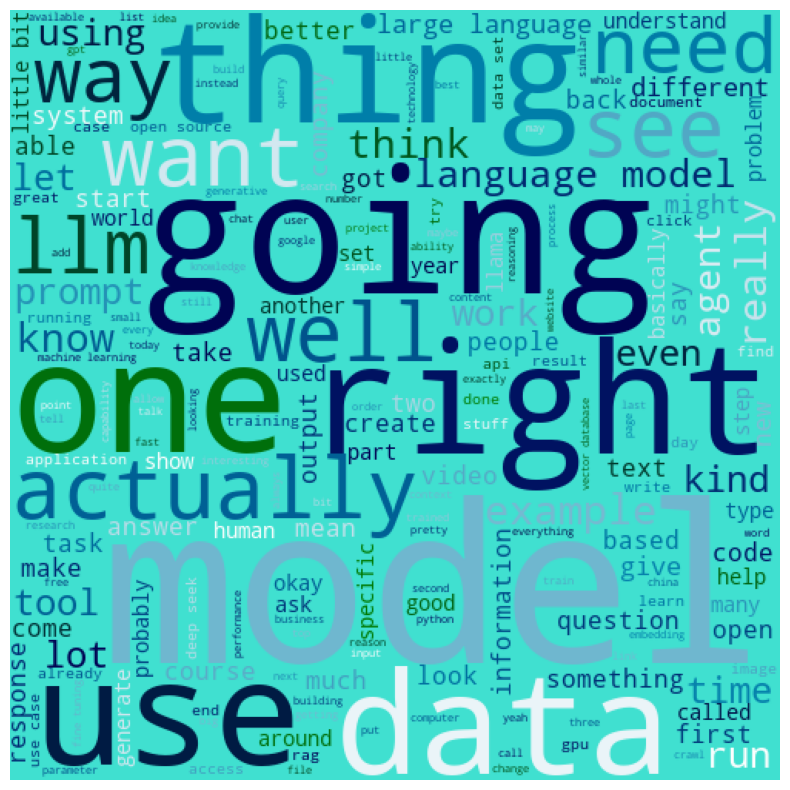

In [16]:
transcript_data = ""
for data in transcripts_pd["cleaned_transcript"]:
    transcript_data = transcript_data+" "+data

plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(transcript_data)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Apply Topic Modeling (LDA)

**Latent Dirichlet Allocation[LDA]:**

LDA algorithm is an unsupervised learning algorithm that works on a probabilistic statistical model to discover topics that the document contains automatically.

This algorithm works on certain assumptions. The assumption is that the document was generated by picking a set of topics and picking a set of words for each topic. In other words, we can say that the document is a probability distribution over the latent topics, and topics are probability distribution over the words.

In [17]:
tokenize_trascript = transcripts_pd.cleaned_transcript.apply(lambda x : x.split())

In [18]:
id2word = corpora.Dictionary(tokenize_trascript)

In [19]:
texts = tokenize_trascript
corpus = [id2word.doc2bow(text) for text in texts]

In [20]:
# building LDA model

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='symmetric',
    eta='symmetric',
    per_word_topics=True
)

In [21]:
pprint(lda_model.print_topics())

[(0,
  '0.013*"model" + 0.012*"like" + 0.009*"china" + 0.007*"learning" + '
  '0.005*"going" + 0.005*"thing" + 0.005*"also" + 0.005*"use" + 0.005*"dog" + '
  '0.005*"right"'),
 (1,
  '0.017*"model" + 0.012*"like" + 0.011*"data" + 0.009*"one" + 0.008*"going" + '
  '0.008*"use" + 0.008*"right" + 0.008*"prompt" + 0.007*"want" + 0.007*"see"'),
 (2,
  '0.030*"model" + 0.011*"thing" + 0.009*"like" + 0.009*"right" + 0.009*"data" '
  '+ 0.007*"think" + 0.007*"one" + 0.007*"use" + 0.006*"let" + '
  '0.006*"learning"'),
 (3,
  '0.016*"model" + 0.012*"going" + 0.010*"agent" + 0.010*"like" + 0.008*"one" '
  '+ 0.007*"time" + 0.007*"llm" + 0.007*"run" + 0.006*"right" + 0.006*"use"'),
 (4,
  '0.020*"model" + 0.017*"like" + 0.008*"going" + 0.008*"llm" + 0.008*"use" + '
  '0.007*"data" + 0.007*"want" + 0.006*"one" + 0.006*"get" + 0.006*"actually"')]


In [22]:
doc_lda = lda_model[corpus]

### Visualize Topics

In [23]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.028074 -0.000355       1        1  38.776680
1      0.057812  0.009703       2        1  19.726509
3      0.029779  0.072909       3        1  16.778699
2      0.014941 -0.092516       4        1  15.813586
0     -0.130606  0.010259       5        1   8.904526, topic_info=          Term         Freq        Total Category  logprob  loglift
1459     agent   188.000000   188.000000  Default  30.0000  30.0000
174      model  1016.000000  1016.000000  Default  29.0000  29.0000
154   learning   140.000000   140.000000  Default  28.0000  28.0000
53       china    44.000000    44.000000  Default  27.0000  27.0000
291      thing   309.000000   309.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
296       time    17.184933   219.581490   Topic5  -5.5898  -0.1291
89        even    15.441633   171.990459   Topic5  -5.6968   0.0082
163       look    14.561836   130.167082   Topic5  -5.7554   0.2282
190       open    14.771877   154.624227   Topic5  -5.7411   0.0703
189        one    14.654920   362.282059   Topic5  -5.7491  -0.7890

[409 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2142      5  0.732533      2011
1936      1  0.112472      2022
1936      4  0.787307      2022
1940      4  0.849204       670
337       1  0.472060  actually
...     ...       ...       ...
328       3  0.131396     would
328       4  0.143341     would
328       5  0.065698     would
4772      3  0.797689       xml
4248      2  0.935249      zoom

[795 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

To measure how good is our model we can use perplexity score and coherence socre. The lower score of perplexity is better for the model.

In [24]:
# Compute Perplexity
print('\nPerplexity : ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_trascript, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity :  -7.362249268948501

Coherence Score:  0.25824509697286435


### Tuning Hyperparameters

In [25]:
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=n, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha=alpha,
                                               per_word_topics=True,
                                               eta=beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_trascript, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda


best_n = None
best_alpha = None
best_beta = None
best_score = -float('inf')

no_of_topics = [2, 5, 7, 10, 12, 14]
alpha_list = ['symmetric', 0.3, 0.5, 0.7]
beta_list = ['auto', 0.3, 0.5, 0.7]

for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")
            
            if coherence_score > best_score:
                best_score = coherence_score
                best_n = n
                best_alpha = alpha
                best_beta = beta

n : 2 ; alpha : symmetric ; beta : auto ; Score : 0.26210984770458734
n : 2 ; alpha : symmetric ; beta : 0.3 ; Score : 0.2505339946321008
n : 2 ; alpha : symmetric ; beta : 0.5 ; Score : 0.26210984770458734
n : 2 ; alpha : symmetric ; beta : 0.7 ; Score : 0.27020703619565134
n : 2 ; alpha : 0.3 ; beta : auto ; Score : 0.26210984770458734
n : 2 ; alpha : 0.3 ; beta : 0.3 ; Score : 0.25053399463210085
n : 2 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.26210984770458734
n : 2 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.27020703619565134
n : 2 ; alpha : 0.5 ; beta : auto ; Score : 0.26210984770458734
n : 2 ; alpha : 0.5 ; beta : 0.3 ; Score : 0.2505339946321008
n : 2 ; alpha : 0.5 ; beta : 0.5 ; Score : 0.26210984770458734
n : 2 ; alpha : 0.5 ; beta : 0.7 ; Score : 0.27020703619565134
n : 2 ; alpha : 0.7 ; beta : auto ; Score : 0.26210984770458734
n : 2 ; alpha : 0.7 ; beta : 0.3 ; Score : 0.25345163336839777
n : 2 ; alpha : 0.7 ; beta : 0.5 ; Score : 0.26210984770458734
n : 2 ; alpha : 0.7 ; beta : 

In [26]:
print(f"\nBest Coherence Score: {best_score}")
print(f"Best n: {best_n}, Best alpha: {best_alpha}, Best beta: {best_beta}")


Best Coherence Score: 0.3963376263371243
Best n: 10, Best alpha: symmetric, Best beta: 0.7


Final LDA Model :

In [27]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=best_n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=best_alpha,
                                           per_word_topics=True,
                                           eta = best_beta)
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_trascript, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3963376263371243


In [28]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.193223  0.015290       1        1  70.738057
4      0.114555 -0.027124       2        1  24.504846
5     -0.025716  0.040498       3        1   2.785398
1     -0.028239  0.000700       4        1   1.058737
7     -0.037166 -0.009697       5        1   0.625738
6     -0.042301 -0.003332       6        1   0.243124
3     -0.041384 -0.004110       7        1   0.011025
2     -0.043294 -0.003720       8        1   0.011025
8     -0.043901 -0.004181       9        1   0.011025
0     -0.045777 -0.004324      10        1   0.011025, topic_info=          Term        Freq       Total Category  logprob  loglift
1459     agent  175.000000  175.000000  Default  30.0000  30.0000
743        say  151.000000  151.000000  Default  29.0000  29.0000
120      going  405.000000  405.000000  Default  28.0000  28.0000
159       like  663.000000  663.000000  Default  27.0000  27.0000
59     company   90.000000   90.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
314      using    0.001112  165.278959  Topic10  -8.5409  -2.7961
232     really    0.001119  231.669606  Topic10  -8.5346  -3.1274
682     little    0.001102  105.717077  Topic10  -8.5506  -2.3590
89        even    0.001107  158.780008  Topic10  -8.5457  -2.7608
151   language    0.001115  230.301706  Topic10  -8.5383  -3.1253

[702 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2142      1  0.389465  2011
2142      2  0.389465  2011
2142      3  0.389465  2011
2144      1  0.433838  2018
2144      2  0.433838  2018
...     ...       ...   ...
4772      1  0.169811   xml
4772      2  0.849055   xml
570       1  0.776868  year
570       2  0.188332  year
570       3  0.023541  year

[827 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 5, 6, 2, 8, 7, 4, 3, 9, 1])

### Topic Modelling using BERTopic

BERTopic is a topic modeling technique based on BERT embeddings, which leverages transformer-based models to create more semantically meaningful topics compared to traditional approaches like Latent Dirichlet Allocation (LDA). It can be especially useful for capturing contextual relationships between words and documents in a way that traditional methods might miss.

There are a number of attributes that you can access after having trained our BERTopic model:


| Attribute | Description |
|------------------------|---------------------------------------------------------------------------------------------|
| topics_               | The topics that are generated for each document after training or updating the topic model. |
| probabilities_ | The probabilities that are generated for each document if HDBSCAN is used. |
| topic_sizes_           | The size of each topic                                                                      |
| topic_mapper_          | A class for tracking topics and their mappings anytime they are merged/reduced.             |
| topic_representations_ | The top *n* terms per topic and their respective c-TF-IDF values.                             |
| c_tf_idf_              | The topic-term matrix as calculated through c-TF-IDF.                                       |
| topic_labels_          | The default labels for each topic.                                                          |
| custom_labels_         | Custom labels for each topic as generated through `.set_topic_labels`.                                                               |
| topic_embeddings_      | The embeddings for each topic if `embedding_model` was used.                                                              |
| representative_docs_   | The representative documents for each topic if HDBSCAN is used.                                                |


In [29]:
cleaned_transcript_list = transcripts_pd["cleaned_transcript"].tolist()

In [30]:
from bertopic import BERTopic

/opt/anaconda3/envs/data_eng/lib/python3.11/site-packages/plotly/express/imshow_utils.py:24: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


In [48]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, min_topic_size=5)
topics, probs = topic_model.fit_transform(cleaned_transcript_list)

2025-03-15 21:26:44,200 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]
2025-03-15 21:26:48,767 - BERTopic - Embedding - Completed ✓
2025-03-15 21:26:48,767 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-15 21:26:48,846 - BERTopic - Dimensionality - Completed ✓
2025-03-15 21:26:48,847 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-15 21:26:48,855 - BERTopic - Cluster - Completed ✓
2025-03-15 21:26:48,856 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-15 21:26:48,884 - BERTopic - Representation - Completed ✓


In [49]:
# Extracting topics and probabilities
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,32,-1_model_like_going_right,"[model, like, going, right, one, want, data, u...",[today going talk indirect prompt injection pe...
1,0,13,0_like_thing_model_think,"[like, thing, model, think, going, people, too...",[jensen hang founder ceo nvidia company heart ...
2,1,12,1_model_data_use_large,"[model, data, use, large, let, language, one, ...",[training model lot easier probably think show...


In [51]:
topic_model.get_topic(0)

[('like', 0.05060162394319719),
 ('thing', 0.041362748866415465),
 ('model', 0.040698318168119994),
 ('think', 0.0334737529535707),
 ('going', 0.03172407570918428),
 ('people', 0.0304645485743725),
 ('tool', 0.02936845409170123),
 ('use', 0.027229482345863528),
 ('student', 0.02672418537541975),
 ('actually', 0.0265266437447089)]

In [52]:
topic_info = topic_model.get_topic_info()
print(topic_info)

   Topic  Count                       Name  \
0     -1     32  -1_model_like_going_right   
1      0     13   0_like_thing_model_think   
2      1     12     1_model_data_use_large   

                                      Representation  \
0  [model, like, going, right, one, want, data, u...   
1  [like, thing, model, think, going, people, too...   
2  [model, data, use, large, let, language, one, ...   

                                 Representative_Docs  
0  [today going talk indirect prompt injection pe...  
1  [jensen hang founder ceo nvidia company heart ...  
2  [training model lot easier probably think show...  


In [53]:
print(len(topic_model.get_topic_freq()))

3


In [54]:
# To access the predicted topics for the first 10 documents
# topic_model.topics_[:10]

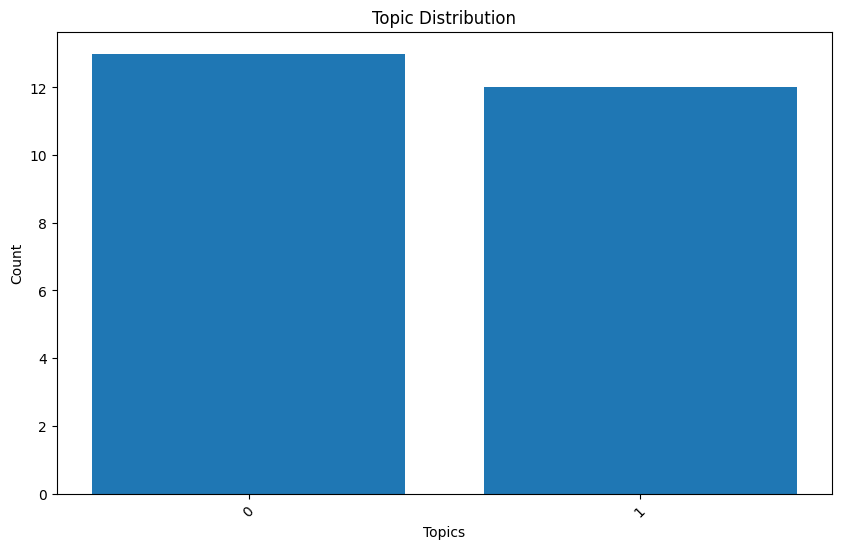

In [55]:
topic_sizes = topic_model.get_topic_freq()
if not topic_sizes.empty and len(topic_sizes) > 1:
    topic_sizes = topic_sizes[topic_sizes.Topic != -1]
    plt.figure(figsize=(10, 6))
    plt.bar(topic_sizes.Topic.astype(str), topic_sizes.Count)
    plt.xlabel('Topics')
    plt.ylabel('Count')
    plt.title('Topic Distribution')
    plt.xticks(rotation=45)
    plt.show()

In [56]:
# topic_model.visualize_topics()

In [58]:
# topic_model.visualize_distribution(probs[2], min_probability=0.015)

#### Cleaning up

In [59]:
spark.catalog.dropTempView("yt_transcripts_table_1")

True

25/03/15 21:40:18 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1 (localhost/127.0.0.1:9092) could not be established. Broker may not be available.
25/03/15 21:40:19 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1 (localhost/127.0.0.1:9092) could not be established. Broker may not be available.
25/03/15 21:40:20 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1 (localhost/127.0.0.1:9092) could not be established. Broker may not be available.
25/03/15 21:40:21 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1 (localhost/127.0.0.1:9092) could not be established. Broker may not be available.
25/03/15 21:40:22 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1 (localhost/127.0.0.1:9092) could not be established. Broker may not be available.
25/03/15 21:40:23 WARN NetworkClient: [AdminClient clientId=adminclient-1] Connection to node 1 (localhost/127